In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 5
commitnumber = d5931a1
conc = None
dv = 0.001
klin = 2e-20
molecule = o3
ng_adju = [0, 0]
ng_refs = [2, 5]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (50, 250)]
tsfc = 257
vmax = 1100
vmin = 980
w_diffuse = [(1.6, 1.75), (1.55, 1.66, 1.7, 1.75, 1.8)]
wgt = [(0.35, 0.6), (0.5, 0.55, 0.7, 0.9, 1.0)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

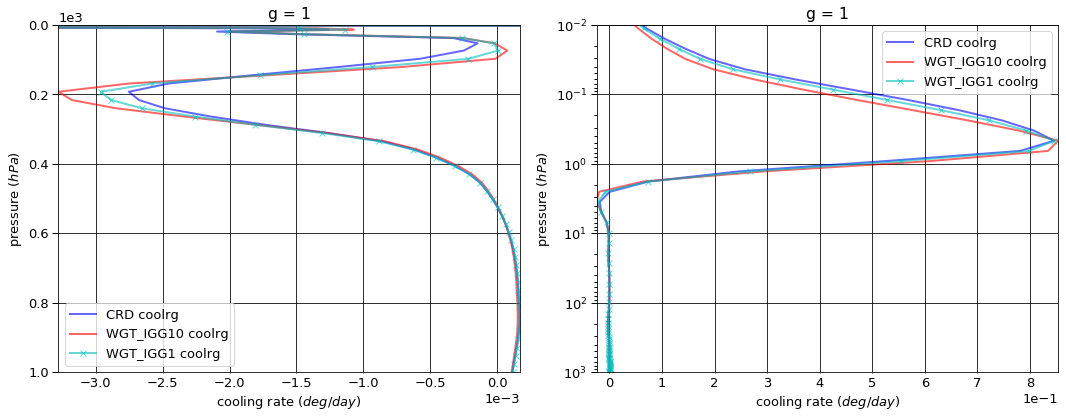

# Figure: cooling rate g-group 2

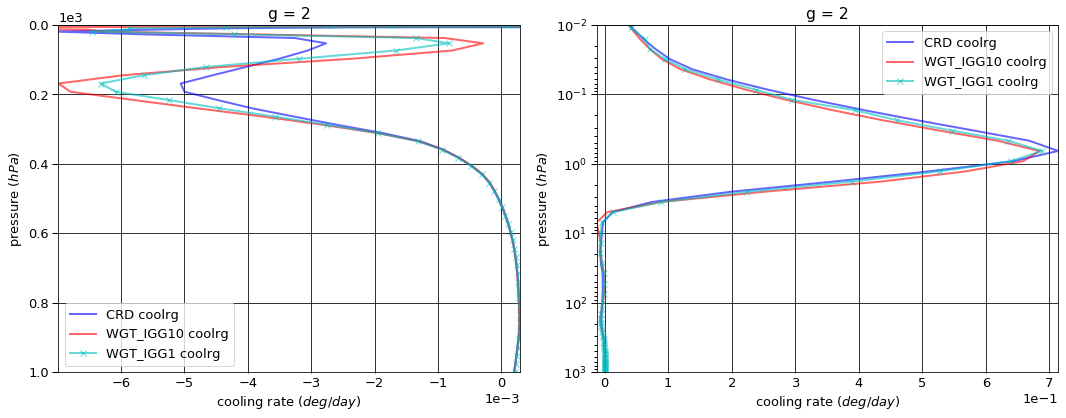

# Figure: cooling rate g-group 3

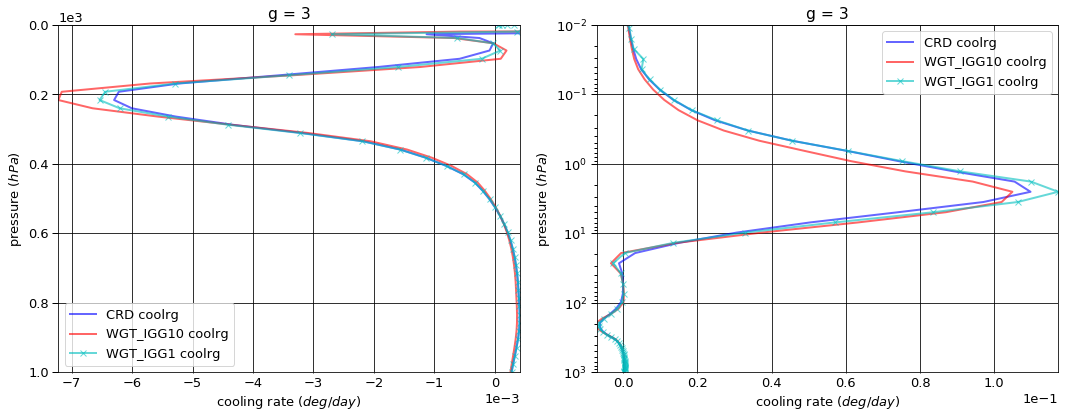

# Figure: cooling rate g-group 4

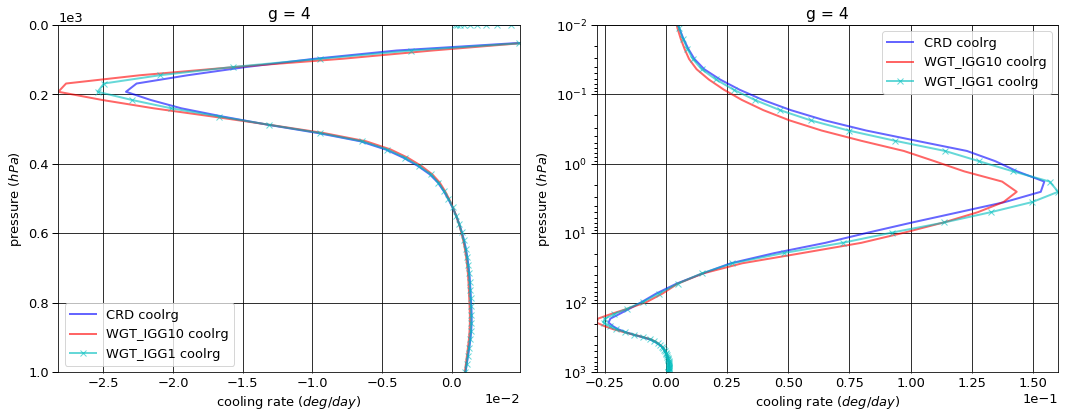

# Figure: cooling rate g-group 5

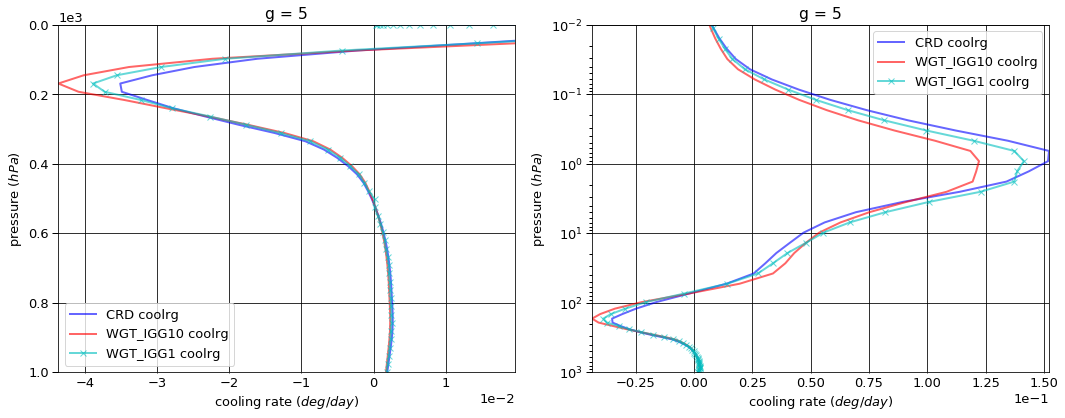

# Figure: cooling rate g-group 6

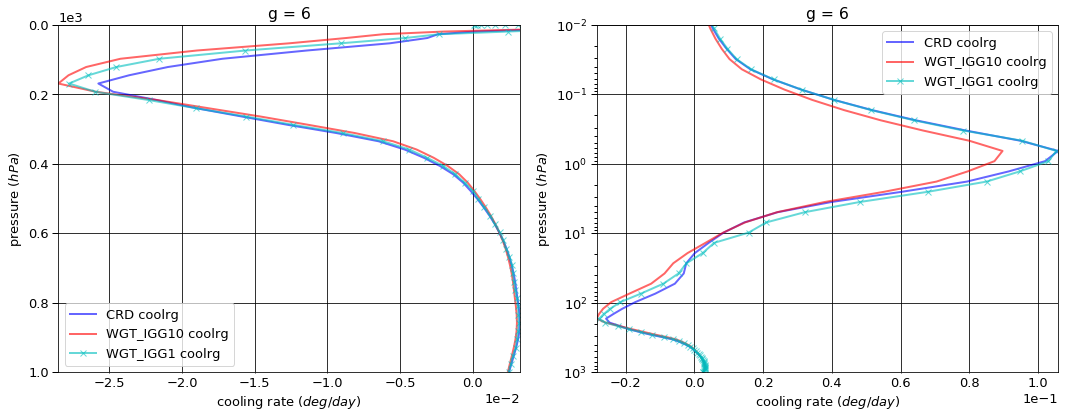

# Figure: cooling rate g-group 7

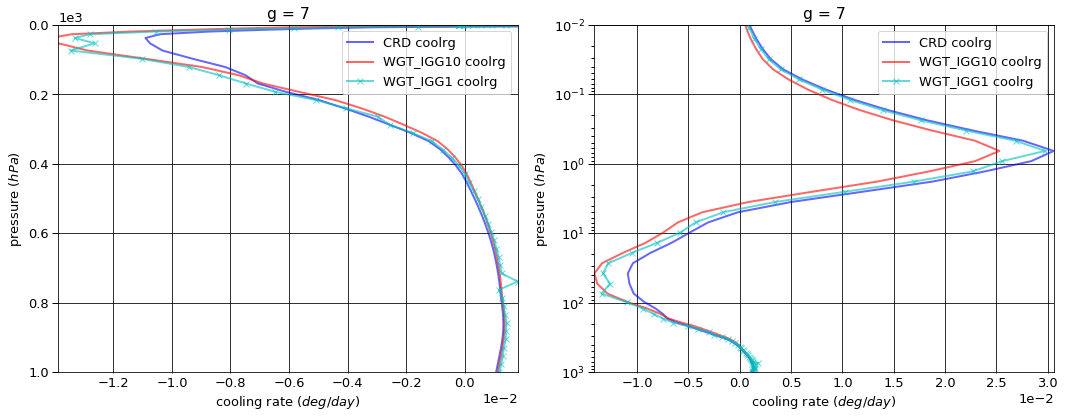

# Figure: cooling rate g-group total

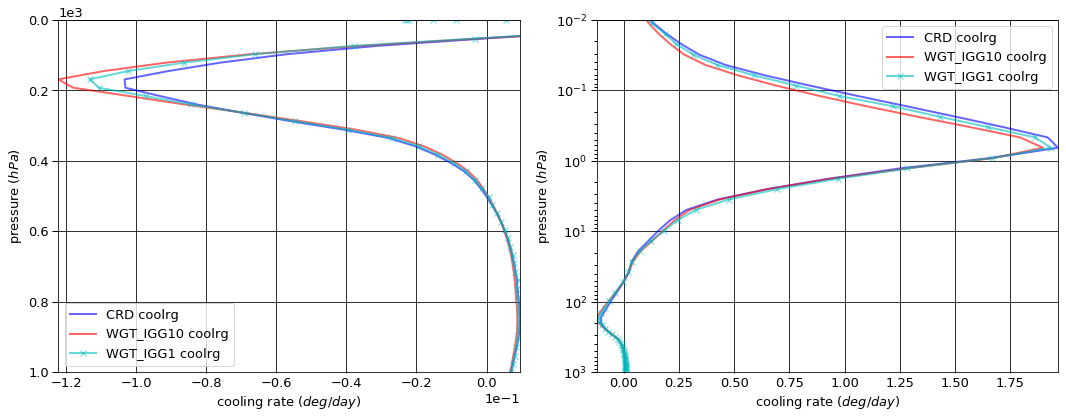

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.090141  0.000000 -0.090141
  1013.0   76    -0.105408  0.048945 -0.056462
2 0.0      1     -0.148091  0.000000 -0.148091
  1013.0   76    -0.234004  0.100396 -0.133608
3 0.0      1     -0.095746  0.000000 -0.095746
  1013.0   76    -0.238444  0.113710 -0.124734
4 0.0      1     -0.343029  0.000000 -0.343029
  1013.0   76    -0.990883  0.442262 -0.548621
5 0.0      1     -0.859799  0.000000 -0.859799
  1013.0   76    -2.136436  0.837901 -1.298535
6 0.0      1     -2.211674  0.000000 -2.211674
  1013.0   76    -3.560104  0.902992 -2.657112
7 0.0      1     -7.246392  0.000000 -7.246392
  1013.0   76    -7.786128  0.357426 -7.428702


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.091493  0.000000 -0.091493
  1013.0   76    -0.105374  0.047907 -0.057467
2 0.0      1     -0.150571  0.000000 -0.150571
  1013.0   76    -0.234024  0.100456 -0.133569
3 0.0      1     -0.095633  0.000000 -0.095633
  1013.0   76    -0.238311  0.110184 -0.128127
4 0.0      1     -0.336156  0.000000 -0.336156
  1013.0   76    -0.990642  0.434283 -0.556359
5 0.0      1     -0.771805  0.000000 -0.771805
  1013.0   76    -2.136799  0.851886 -1.284912
6 0.0      1     -2.066645  0.000000 -2.066645
  1013.0   76    -3.563155  0.958218 -2.604937
7 0.0      1     -7.198958  0.000000 -7.198958
  1013.0   76    -7.783102  0.380837 -7.402265


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.090699  0.000000 -0.090699
  1013.0   76    -0.105374  0.049230 -0.056144
2 0.0      1     -0.148260  0.000000 -0.148260
  1013.0   76    -0.234024  0.101312 -0.132712
3 0.0      1     -0.097386  0.000000 -0.097386
  1013.0   76    -0.238311  0.114064 -0.124246
4 0.0      1     -0.340325  0.000000 -0.340325
  1013.0   76    -0.990642  0.442448 -0.548194
5 0.0      1     -0.820028  0.000000 -0.820028
  1013.0   76    -2.136799  0.843367 -1.293431
6 0.0      1     -2.142002  0.000000 -2.142002
  1013.0   76    -3.563155  0.931112 -2.632043
7 0.0      1     -7.178297  0.000000 -7.178297
  1013.0   76    -7.783102  0.396642 -7.386460


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001352  0.000000 -0.001352
  1013.0   76     0.000034 -0.001038 -0.001004
2 0.0      1     -0.002480  0.000000 -0.002480
  1013.0   76    -0.000020  0.000059  0.000039
3 0.0      1      0.000114  0.000000  0.000114
  1013.0   76     0.000133 -0.003526 -0.003393
4 0.0      1      0.006873  0.000000  0.006873
  1013.0   76     0.000241 -0.007979 -0.007738
5 0.0      1      0.087994  0.000000  0.087994
  1013.0   76    -0.000363  0.013985  0.013622
6 0.0      1      0.145029  0.000000  0.145029
  1013.0   76    -0.003051  0.055226  0.052175
7 0.0      1      0.047434  0.000000  0.047434
  1013.0   76     0.003026  0.023411  0.026437


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000558  0.000000 -0.000558
  1013.0   76     0.000034  0.000285  0.000319
2 0.0      1     -0.000170  0.000000 -0.000170
  1013.0   76    -0.000020  0.000916  0.000896
3 0.0      1     -0.001640  0.000000 -0.001640
  1013.0   76     0.000133  0.000354  0.000487
4 0.0      1      0.002704  0.000000  0.002704
  1013.0   76     0.000241  0.000186  0.000426
5 0.0      1      0.039770  0.000000  0.039770
  1013.0   76    -0.000363  0.005466  0.005103
6 0.0      1      0.069671  0.000000  0.069671
  1013.0   76    -0.003051  0.028120  0.025069
7 0.0      1      0.068095  0.000000  0.068095
  1013.0   76     0.003026  0.039216  0.042242

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.024109
  1001.112500 75     0.000113
2 0.000312    1     -0.004131
  1001.112500 75     0.000200
3 0.000312    1      0.000013
  1001.112500 75     0.000276
4 0.000312    1      0.000116
  1001.112500 75     0.000980
5 0.000312    1      0.000171
  1001.112500 75     0.001895
6 0.000312    1     -0.000033
  1001.112500 75     0.002475
7 0.000312    1     -0.000141
  1001.112500 75     0.001078


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1     -0.015589
  1001.112500 75     0.000109
2 0.000312    1     -0.001398
  1001.112500 75     0.000203
3 0.000312    1      0.000052
  1001.112500 75     0.000259
4 0.000312    1      0.000252
  1001.112500 75     0.000934
5 0.000312    1      0.000353
  1001.112500 75     0.001715
6 0.000312    1     -0.000018
  1001.112500 75     0.002397
7 0.000312    1     -0.000200
  1001.112500 75     0.001136


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1     -0.020054
  1001.112500 75     0.000115
2 0.000312    1     -0.002761
  1001.112500 75     0.000205
3 0.000312    1      0.000046
  1001.112500 75     0.000279
4 0.000312    1      0.000256
  1001.112500 75     0.000977
5 0.000312    1      0.000385
  1001.112500 75     0.001815
6 0.000312    1      0.000060
  1001.112500 75     0.002462
7 0.000312    1     -0.000179
  1001.112500 75     0.001194


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.008521
  1001.112500 75    -0.000004
2 0.000312    1      0.002733
  1001.112500 75     0.000003
3 0.000312    1      0.000040
  1001.112500 75    -0.000018
4 0.000312    1      0.000136
  1001.112500 75    -0.000046
5 0.000312    1      0.000182
  1001.112500 75    -0.000181
6 0.000312    1      0.000015
  1001.112500 75    -0.000078
7 0.000312    1     -0.000059
  1001.112500 75     0.000058


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.004056
  1001.112500 75     0.000002
2 0.000312    1      0.001370
  1001.112500 75     0.000006
3 0.000312    1      0.000033
  1001.112500 75     0.000003
4 0.000312    1      0.000140
  1001.112500 75    -0.000003
5 0.000312    1      0.000214
  1001.112500 75    -0.000080
6 0.000312    1      0.000093
  1001.112500 75    -0.000013
7 0.000312    1     -0.000038
  1001.112500 75     0.000115

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-10.994872,0.000000,-10.994872
1013.0,76,-15.051406,2.803633,-12.247774



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-10.711261,0.000000,-10.711261
1013.0,76,-15.051406,2.883771,-12.167636



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-10.816998,0.000000,-10.816998
1013.0,76,-15.051406,2.878175,-12.173231



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.836113e-01,0.000000,0.283611
1013.0,76,1.100000e-07,0.080138,0.080138



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.778741e-01,0.000000,0.177874
1013.0,76,1.100000e-07,0.074543,0.074543


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.028115
1001.112500,75,0.007018



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.016547
1001.112500,75,0.006753



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.022247
1001.112500,75,0.007047



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.011568
1001.112500,75,-0.000264



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.005868
1001.112500,75,0.000029


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.007008,0.007001
2,0.015458,0.015548
3,0.015917,0.015833
4,0.065800,0.065817
5,0.140908,0.141967
6,0.232192,0.236732
7,0.522717,0.517101


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.107750e-18
2,7.729691e-19
3,1.023108e-18
4,2.756166e-19
5,7.424874e-20
6,2.000197e-20
7,1.116904e-22


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.107750e-18,NaN,0.007008,0.007001,0.007008,0.007001,1.0
2,7.729691e-19,0.151333,0.015458,0.015548,0.022467,0.022549,1.0
3,1.023108e-18,1.323608,0.015917,0.015833,0.038383,0.038382,50.0
4,2.756166e-19,0.269391,0.065800,0.065817,0.104183,0.104200,50.0
5,7.424874e-20,0.269391,0.140908,0.141967,0.245092,0.246166,50.0
6,2.000197e-20,0.269391,0.232192,0.236732,0.477283,0.482899,50.0
7,1.116904e-22,0.005584,0.522717,0.517101,1.000000,1.000000,50.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
